# Exploration of access to OMNI and RTSW data

In [1]:
%load_ext autoreload
%autoreload 2

from copy import deepcopy
import datetime as dt
import numpy as np
import pandas as pd
import xarray as xr
from hapiclient import hapi, hapitime2datetime
import matplotlib.pyplot as plt
from sunpy.coordinates import GeocentricSolarMagnetospheric, GeocentricSolarEcliptic
from astropy import units as u
from astropy.coordinates import SkyCoord

%matplotlib inline

In [2]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning, module="hapiclient")

In [3]:
START = "2025-03-01T00:00:00Z"
STOP = "2025-03-04T00:00:00.000Z"

## Fetching data from HAPI (CDAWeb and CCMC ISWA)

In [4]:
def to_pandas(hapidata):
    df = pd.DataFrame(
        columns=hapidata.dtype.names,
        data=hapidata,
    ).set_index("Time")
    # Convert from hapitime to Python datetime and remove timezone awareness
    df.index = hapitime2datetime(df.index.values.astype(str))
    df.index = df.index.tz_convert("UTC").tz_convert(None)
    df.index.name = "Time"
    return df


def get_units_description(hapimeta):
    units = {}
    description = {}
    for paramdict in hapimeta["parameters"]:
        units[paramdict["name"]] = paramdict.get("units", None)
        description[paramdict["name"]] = paramdict.get("description", None)
    return units, description


def to_xarray(hapidata, hapimeta):
    ds = to_pandas(hapidata).to_xarray()
    units, description = get_units_description(hapimeta)
    for param in ds:
        ds[param].attrs = {"units": units[param], "description": description[param]}
    return ds


def fill2nan(hapidata, hapimeta):
    """Replace bad values (fill values given in metadata) with NaN"""
    hapidata = deepcopy(hapidata)
    for metavar in hapimeta["parameters"]:
        varname = metavar["name"]
        fillvalstr = metavar["fill"]
        if fillvalstr is None:
            continue
        vardata = hapidata[varname]
        mask = vardata == float(fillvalstr)
        nbad = np.count_nonzero(mask)
        print("{}: {} fills NaN'd".format(varname, nbad))
        vardata[mask] = np.nan
    return hapidata, hapimeta


def fetch_cdaweb_omni(start, stop):
    # https://cdaweb.gsfc.nasa.gov/registry/hdp/hapi/
    server = "https://cdaweb.gsfc.nasa.gov/hapi"
    dataset = "OMNI_HRO2_1MIN"
    parameters = "BX_GSE,BY_GSM,BZ_GSM,flow_speed"
    data, meta = hapi(server, dataset, parameters, start, stop)
    data, meta = fill2nan(data, meta)
    return to_xarray(data, meta)


def fetch_iswa_swpc_rtsw_mag(start, stop):
    # https://ccmc.gsfc.nasa.gov/tools/ISWA/
    server = "https://iswa.gsfc.nasa.gov/IswaSystemWebApp/hapi"
    dataset = "swpc_rtsw_mag_P1M"
    parameters = "B_x,B_y,B_z,Latitude,Longitude"
    data, meta = hapi(server, dataset, parameters, start, stop)
    data, meta = fill2nan(data, meta)
    return to_xarray(data, meta)


def fetch_iswa_swpc_rtsw_plasma(start, stop):
    # https://ccmc.gsfc.nasa.gov/tools/ISWA/
    server = "https://iswa.gsfc.nasa.gov/IswaSystemWebApp/hapi"
    dataset = "swpc_rtsw_plasma_P1M"
    parameters = "BulkSpeed"
    data, meta = hapi(server, dataset, parameters, start, stop)
    data, meta = fill2nan(data, meta)
    return to_xarray(data, meta)

### OMNI via HAPI

OMNI HRO2 1MIN represents our "ideal" data. Data originates from multiple spacecraft depending on best availability (usually ACE). Data are processed to include propagation of the solar wind measurements at L1 to their arrival time at Earth's magnetosphere nose, and are definitive (they do not change).

In [5]:
ds_omni = fetch_cdaweb_omni("2024-12-21T00:00:00Z", "2025-01-01T00:00:00Z")
ds_omni

BX_GSE: 7421 fills NaN'd
BY_GSM: 7421 fills NaN'd
BZ_GSM: 7421 fills NaN'd
flow_speed: 10210 fills NaN'd


<xarray.Dataset> Size: 634kB
Dimensions:     (Time: 15840)
Coordinates:
  * Time        (Time) datetime64[ns] 127kB 2024-12-21 ... 2024-12-31T23:59:00
Data variables:
    BX_GSE      (Time) float64 127kB 5.79 5.76 5.51 5.73 ... nan nan nan nan
    BY_GSM      (Time) float64 127kB -5.03 -4.84 -3.43 -4.64 ... nan nan nan nan
    BZ_GSM      (Time) float64 127kB 2.2 2.62 3.5 2.62 3.19 ... nan nan nan nan
    flow_speed  (Time) float64 127kB 461.0 455.2 467.0 465.9 ... nan nan nan nan

There's an awful lot of gaps in there 🤔 - in fact they are over the last four days - so beware that the real data availability interval is less than that reported by the hapi server.

### SWPC RTSW via CCMC/ISWA HAPI

SWPC realtime solar wind data are available within a few minutes of measurement, but are of lower quality. The ISWA service provides HAPI access to some of the SWPC data with a few extra minutes delay.

In [6]:
start = "2025-01-01T00:00:00Z"
stop = "2025-01-05T00:00:00Z"
ds_rtsw = xr.merge(
    [fetch_iswa_swpc_rtsw_mag(start, stop), fetch_iswa_swpc_rtsw_plasma(start, stop)],
)
ds_rtsw

B_x: 0 fills NaN'd
B_y: 0 fills NaN'd
B_z: 0 fills NaN'd
Latitude: 2 fills NaN'd
Longitude: 0 fills NaN'd
BulkSpeed: 0 fills NaN'd


<xarray.Dataset> Size: 305kB
Dimensions:    (Time: 5454)
Coordinates:
  * Time       (Time) datetime64[ns] 44kB 2025-01-01 ... 2025-01-04T23:59:00
Data variables:
    B_x        (Time) float64 44kB -6.88 -8.24 -9.07 -9.24 ... -3.42 -4.58 -5.15
    B_y        (Time) float64 44kB 13.5 12.92 12.46 12.34 ... 2.25 3.56 3.27
    B_z        (Time) float64 44kB -1.72 -1.86 -2.18 -2.58 ... -2.02 -1.88 0.02
    Latitude   (Time) float64 44kB -6.49 -6.91 -8.05 ... -26.33 -17.93 0.18
    Longitude  (Time) float64 44kB 117.0 122.5 126.0 126.8 ... 146.7 142.1 147.6
    BulkSpeed  (Time) float64 44kB 435.4 470.2 430.0 397.2 ... 649.7 655.3 656.8

## Direct RTSW from SWPC

This is the soonest available solar wind data, provided by NOAA as an operational space weather service. (ISWA is a few minutes delayed and does not provide all the parameters). Similarly to OMNI, they can originate from different spacecraft (mostly ACE).

More details available here:  
https://www.spaceweather.gov/products/real-time-solar-wind

Availability:
- in json for the past 7 days:  
  https://services.swpc.noaa.gov/products/solar-wind/
  - Ephemerides at 1-hour resolution:  
    https://services.swpc.noaa.gov/products/solar-wind/ephemerides.json
  - Magnetic data at 1-minute resolution:  
    https://services.swpc.noaa.gov/products/solar-wind/mag-7-day.json
  - Plasma data at 1-minute resolution:  
    https://services.swpc.noaa.gov/products/solar-wind/plasma-7-day.json
- in json for the past 24 hours:  
  https://services.swpc.noaa.gov/json/rtsw/  
  https://services.swpc.noaa.gov/json/rtsw/rtsw_ephemerides_1h.json  
  https://services.swpc.noaa.gov/json/rtsw/rtsw_mag_1m.json  
  https://services.swpc.noaa.gov/json/rtsw/rtsw_wind_1m.json  
- in json **with time shifting applied**:  
  https://services.swpc.noaa.gov/products/geospace/  
  - past hour:  
    https://services.swpc.noaa.gov/products/geospace/propagated-solar-wind-1-hour.json  
  - past 7 days:  
    https://services.swpc.noaa.gov/products/geospace/propagated-solar-wind.json

*(Is it possible to get past ~6 months from SWPC? / whatever the maximum delay of OMNI release is)*

In [7]:
datasources_swpc = {
    "ephemerides": "https://services.swpc.noaa.gov/products/solar-wind/ephemerides.json",
    "mag-7-day": "https://services.swpc.noaa.gov/products/solar-wind/mag-7-day.json",
    "plasma-7-day": "https://services.swpc.noaa.gov/products/solar-wind/plasma-7-day.json",
    "rtsw_ephemerides_1h": "https://services.swpc.noaa.gov/json/rtsw/rtsw_ephemerides_1h.json",
    "rtsw_mag_1m": "https://services.swpc.noaa.gov/json/rtsw/rtsw_mag_1m.json",
    "rtsw_wind_1m": "https://services.swpc.noaa.gov/json/rtsw/rtsw_wind_1m.json",
    "propagated-solar-wind-1-hour": "https://services.swpc.noaa.gov/products/geospace/propagated-solar-wind-1-hour.json",
    "propagated-solar-wind": "https://services.swpc.noaa.gov/products/geospace/propagated-solar-wind.json",
}

In [8]:
def fetch_json(url):
    df = pd.read_json(url)
    # wrangle format
    df.columns = df.iloc[0]
    df = df.drop(0)
    df = df.set_index("time_tag")
    df.index = pd.to_datetime(df.index)
    datavars = list(df.columns)
    timevar = "propagated_time_tag"
    datavars = [v for v in datavars if v != timevar]
    df[datavars] = df[datavars].astype(float)
    if timevar in df.columns:
        df[timevar] = pd.DatetimeIndex(df[timevar])
    return df

### SWPC propagated solar wind product

In [9]:
df_propagated_solar_wind = fetch_json(datasources_swpc["propagated-solar-wind"])
df_propagated_solar_wind

,speed,density,temperature,bx,by,bz,bt,vx,vy,vz,propagated_time_tag
time_tag,,,,,,,,,,,
2025-03-05 00:00:00,477.1,2.87,158633.0,-1.77,7.25,-1.85,7.69,NaN,NaN,NaN,2025-03-05 00:45:00
2025-03-05 00:01:00,473.5,2.54,102013.0,-0.19,7.37,-0.65,7.40,NaN,NaN,NaN,2025-03-05 00:46:20
2025-03-05 00:02:00,471.1,2.31,72833.0,0.08,7.36,-1.08,7.44,NaN,NaN,NaN,2025-03-05 00:47:34
2025-03-05 00:03:00,485.2,3.33,130604.0,0.91,7.30,0.44,7.37,NaN,NaN,NaN,2025-03-05 00:47:15
2025-03-05 00:04:00,500.3,3.84,191909.0,0.10,7.45,-0.27,7.46,NaN,NaN,NaN,2025-03-05 00:46:55
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-12 18:14:00,485.9,0.93,76891.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-12 18:57:18
2025-03-12 18:15:00,557.8,0.38,146450.0,5.27,-2.49,-6.98,9.09,NaN,NaN,NaN,2025-03-12 18:52:43
2025-03-12 18:16:00,557.0,0.26,121657.0,4.54,-2.74,-7.38,9.09,NaN,NaN,NaN,2025-03-12 18:53:47


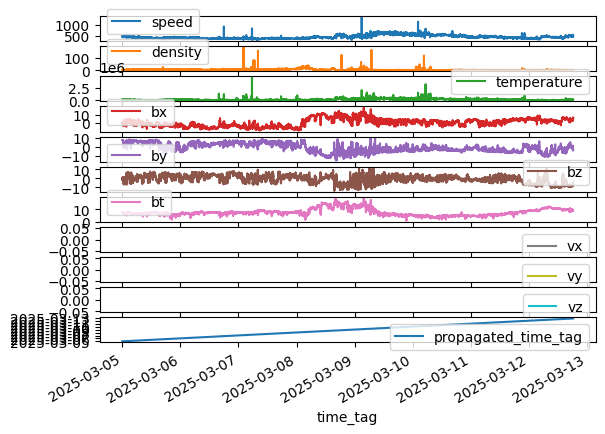

In [10]:
_ = df_propagated_solar_wind.plot(subplots=True)

### SWPC unpropagated products

In [11]:
df_ephemerides = fetch_json(datasources_swpc["ephemerides"])

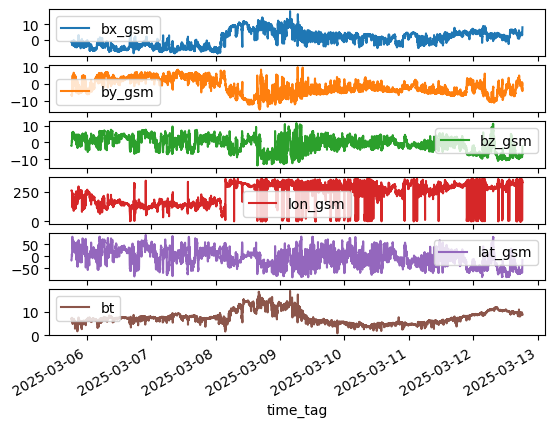

In [12]:
df_mag = fetch_json(datasources_swpc["mag-7-day"])
_ = df_mag.plot(subplots=True)

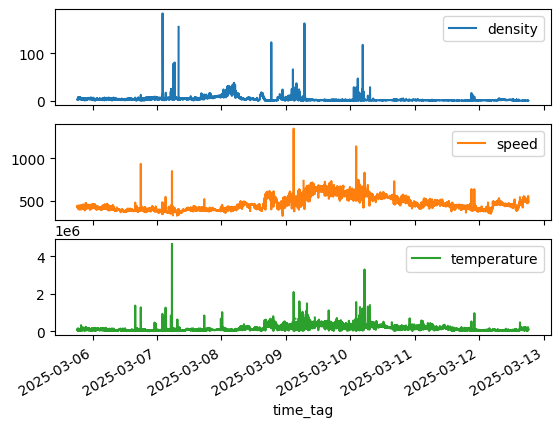

In [13]:
df_plasma = fetch_json(datasources_swpc["plasma-7-day"])
_ = df_plasma.plot(subplots=True)

#### Calculating time shift to apply

Time shift is dependent on spacecraft position and solar wind speed.

---

OMNI LRO (low resolution = 1 hour)

https://omniweb.gsfc.nasa.gov/html/ow_data.html#time_shift

```
Delta-t = (X/V) * {[1 + (Y*W)/X]/[1 - Ve*W/V]}, 
where 
Delta-t is the time shift in seconds, 
X and Y are GSE X and Y components of the spacecraft position vector, in km, 
V is the observed solar wind speed in km/s (assumed radial),
Ve is the speed of the Earth's orbital motion (30 km/s). 
W=tan [0.5 * atan (V/428)] is parameter related to the assumed orientation of the phase front relative
  to the Earth-sun line.  It is Half-way between corotation geometry and convection geometry.
```

---

OMNI/OMNI2 HRO (high resolution = 1 minute)

https://omniweb.gsfc.nasa.gov/html/HROdocum.html#3

King, J. H., and N. E. Papitashvili (2005), Solar wind spatial scales in and comparisons of hourly Wind and ACE plasma and magnetic field data, J. Geophys. Res., 110, A02104, [doi:10.1029/2004JA010649](https://doi.org/10.1029/2004JA010649). 

In [14]:
def calc_time_shift(df_ephemerides=df_ephemerides, df_plasma=df_plasma):
    df_ephemerides_1_minute = df_ephemerides.reindex(df_plasma.index).interpolate(
        method="linear"
    )
    X = df_ephemerides_1_minute["x_gse"].values  # in km
    Y = df_ephemerides_1_minute["y_gse"].values  # in km
    V = df_plasma["speed"].values  # in km/s
    Ve = 30
    W = np.tan(0.5 * np.arctan2(V, 428))
    delta_t = (X / V) * ((1 + (Y * W) / X) / (1 - Ve * W / V))
    return delta_t

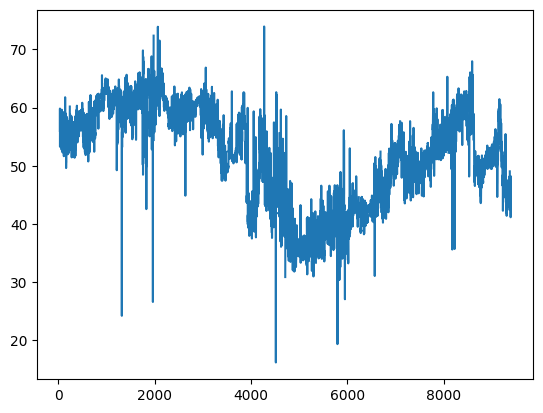

In [15]:
delta_t = calc_time_shift(df_ephemerides, df_plasma)
# NB Do something about the spikes
_ = plt.plot(delta_t / 60)

(compares somewhat well with the SWPC-provided propagations but is not quite the same, several minutes out)

## Use SWPC propagated data

The propagated times are not monotic and can contain duplicates so this needs to be resolved.

In [16]:
df_propagated_solar_wind = fetch_json(datasources_swpc["propagated-solar-wind"])

In [17]:
df_propagated_solar_wind.index.is_monotonic_increasing

True

In [18]:
df_propagated_solar_wind["propagated_time_tag"].is_monotonic_increasing

False

In [19]:
# Reorganise time series with "propagated_time_tag" as the index
df = df_propagated_solar_wind.copy()
df = df.drop(columns=["density", "temperature", "bt", "vx", "vy", "vz"])
df = df.set_index("propagated_time_tag")
df = df.sort_index()
df = df[~df.index.duplicated(keep="first")]
# Generate new UTC-minute-aligned index within the interval
t = df.index[0].to_pydatetime()
t_start = dt.datetime(t.year, t.month, t.day, t.hour, t.minute + 1, 0)
t = df.index[-1].to_pydatetime()
t_end = dt.datetime(t.year, t.month, t.day, t.hour, t.minute, 0)
utc_times = pd.date_range(t_start, t_end, freq="min")
new_index = utc_times.union(df.index).drop_duplicates()
# Interpolate original time series onto the UTC minutes
df = df.reindex(new_index).interpolate(method="linear")
df = df.reindex(utc_times)
df

,speed,bx,by,bz
2025-03-05 00:46:00,475.300000,-0.980000,7.310000,-1.250
2025-03-05 00:47:00,492.750000,0.505000,7.375000,0.085
2025-03-05 00:48:00,481.400000,0.185000,7.350000,-0.840
2025-03-05 00:49:00,487.333333,0.203333,7.293333,-0.820
2025-03-05 00:50:00,482.966667,0.116667,7.246667,-1.040
...,...,...,...,...
2025-03-12 18:57:00,500.120000,5.402222,-3.353333,-6.100
2025-03-12 18:58:00,486.600000,5.833333,-3.660000,-5.460
2025-03-12 18:59:00,487.300000,6.048889,-3.813333,-5.140
2025-03-12 19:00:00,488.000000,6.264444,-3.966667,-4.820


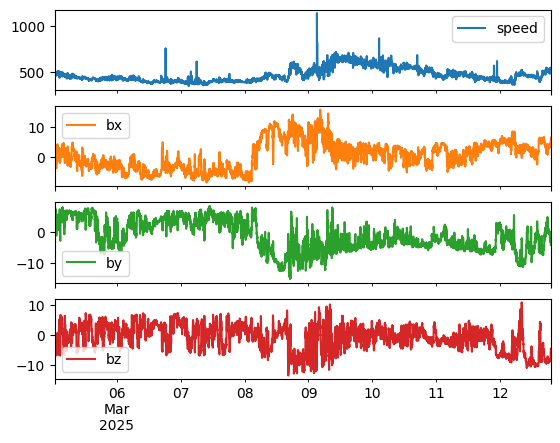

In [20]:
_ = df.plot(subplots=True)

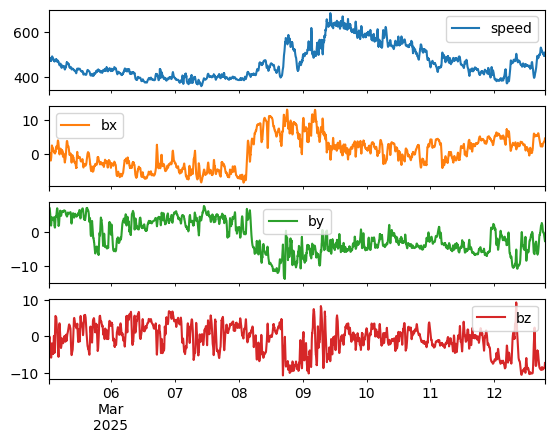

In [21]:
_ = df.rolling("20min").mean().plot(subplots=True)

## Notes

- TODO:
    - Confirm bx,by,bz are in GSM coordinates like OMNI
    - Find if SWPC provide bulk download of past X months (not just past 7 days)
    - Verify / fix process of getting propagated timeseries
    - Check for fill values and possible spike removal
    - Investigate using only ACE data directly
    - Check how to merge the OMNI and rtsw safely
    - [ESA SWE](https://swe.ssa.esa.int) mirror the swpc rtsw (but not the propagated version). Might be available over their internal HAPI server (requires extra steps...)
    - Document and create exact procedure for 20-minute smoothing for input to models
    - Equivalent for F10.7 series
- Playing with marimo: https://marimo.app/l/vbw0oq

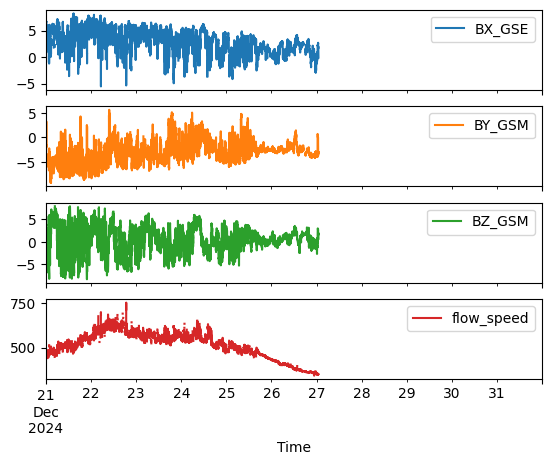

In [22]:
df_omni = ds_omni.to_dataframe()
_ = df_omni.plot(subplots=True)

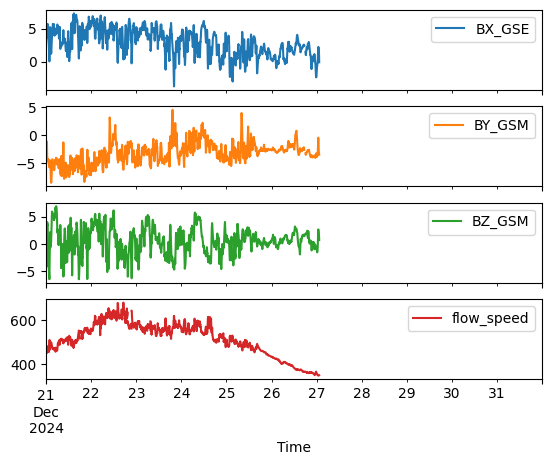

In [23]:
_ = df_omni.rolling("20min").mean().plot(subplots=True)